# Reporting

It is useful to see how to report the results from valence and export them to a formate which can be used in other applications. Here, it is demonstrated how to:
1. Plot chromatograms and Mass Spectra using `matlibplot`.
2. Report data in pivot tables using `pandas`.
3. Plot bar charts of the data using `bokeh`.

Below is the following code from the `valence_build` and `valence_analyze` notebooks. After executing this code this 1notebook will demonstrate some methods for plotting and reporting the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from valence.build import AgilentGcms
from valence.analyze import match_area, std_curves, concentrations
from bkcharts import Bar, show, output_notebook
from bokeh.io import export_png
%matplotlib inline

In [2]:
agi = AgilentGcms.from_root('data')

In [3]:
lib = agi.results_lib
area = agi.results_tic
stnd = pd.read_csv('data\standards.csv')

In [4]:
comp = match_area(lib,area)
curves = std_curves(comp,stnd)
conc = concentrations(comp,curves)

## Plotting Chromatograms
First get the chromatogram data from valence

In [5]:
chroms = agi.chromatogram

Below is an example function using `matlibplot` which plots all of the chromatograms in one figure. The function can be customized to do more. We are working on a package to include this functionality.

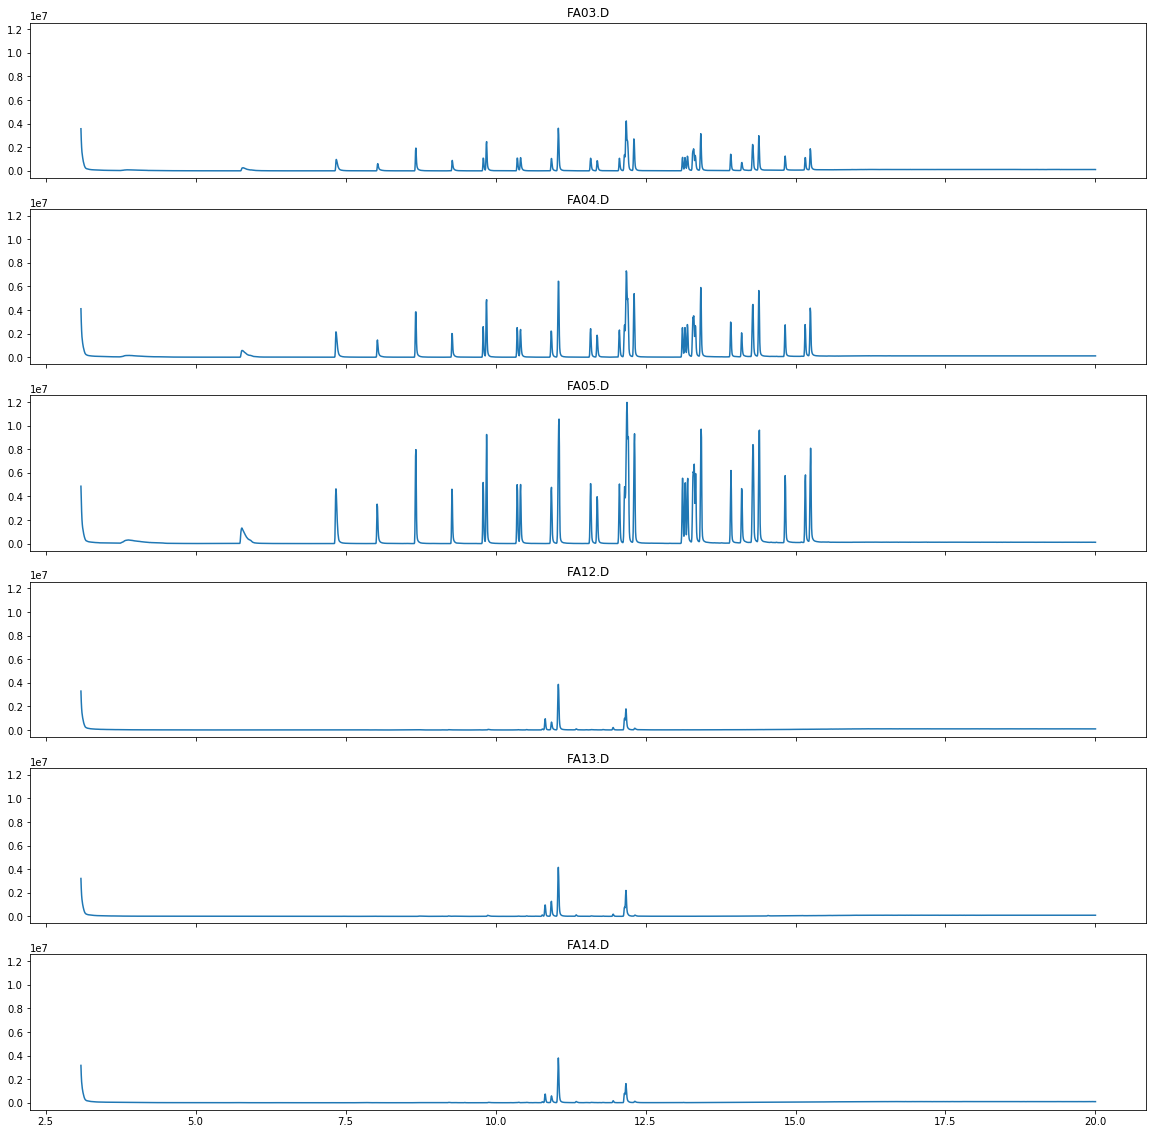

In [6]:
def plot_chroms(chroms):
    fig_name= sorted(list(set(chroms.index)))
    f, (figs) = plt.subplots(len(fig_name),sharex=True,sharey=True)
    for i in range(len(fig_name)):
        figs[i].plot(chroms.loc[fig_name[i]].tme,chroms.loc[fig_name[i]].tic)
        figs[i].set_title(fig_name[i])

    f.set_figheight(20)
    f.set_figwidth(20)
    return f
chromatogramplot = plot_chroms(chroms)

9.197966666666666

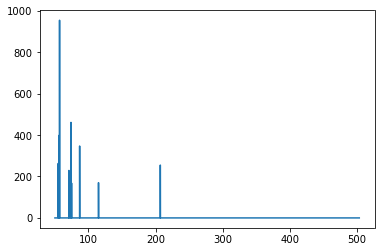

In [7]:
s = agi.spectra['FA03.D']
time = 9.2
i = s.index.get_loc(time,method='nearest',tolerance=.1)
ms = s.iloc[i].sort_index()
plt.plot(ms.keys(),ms.values)
s.iloc[i].name

Save the file to a pdf to view or put in reports.

In [8]:
chromatogramplot.savefig("chromatograms.pdf", bbox_inches='tight')

## Building Pivot Tables
If you are used to excel you are probably familiar with pivot tables. They are an easy way to organize, manipulate and report data. Fortunately `pandas` has this capability as well. Below is an example of how to create two pivot tables and same them to a `.csv`. The first is a pivot table of the area percentages. The second is a pivot table of just the concentrations from the experimental files (i.e. standards are removed from the table)

In [9]:
pvt_areapercent = pd.pivot_table(comp.reset_index(),
                                 values='area%',
                                columns = 'key',
                                index = 'library_id')
pvt_areapercent.head().round(3)

key,FA03.D,FA04.D,FA05.D,FA12.D,FA13.D,FA14.D
library_id,,,,,,
"All cis-4,7,10,13,16,19-docosahexaenoate methyl ester",0.015,0.018,0.022,NaN,NaN,NaN
Methyl arachidate,0.058,0.053,0.049,NaN,NaN,NaN
Methyl arachidonate,0.019,0.020,0.023,NaN,NaN,NaN
"Methyl cis-11,14,17-eicosatrienoate",NaN,0.020,0.023,NaN,NaN,NaN
Methyl cis-11-eicosenoate,0.052,0.050,0.052,NaN,NaN,NaN


In [10]:
stndkeys = set(stnd.keys()[1:])
conc_exp = conc[~conc.index.isin(stndkeys)]
pvt_conc_exp = pd.pivot_table(conc_exp.reset_index(),
                                 values='conc',
                                columns = 'key',
                                index = 'library_id')
pvt_conc_exp.round(2)

key,FA12.D,FA13.D,FA14.D
library_id,,,
Methyl myristate,NaN,NaN,NaN
Methyl palmitate,NaN,0.27,0.25
Methyl palmitoleate,0.17,0.31,0.16
Methyl stearate,NaN,NaN,NaN
Phenol,NaN,NaN,NaN
cis-9-Oleic methyl ester,NaN,NaN,NaN


This data can now be saved to a `.csv`.

In [11]:
stnd.head()

,library_id,FA03.D,FA04.D,FA05.D
0,Methyl palmitate,0.25,0.5,1
1,Methyl heptadecanoate,0.25,0.5,1
2,Methyl docosanoate,0.25,0.5,1
3,Methyl undecanoate,0.25,0.5,1
4,"Methyl cis-8,11,14-eicosatrienoate",0.25,0.5,1


In [12]:
pvt_conc_exp.to_csv('concentrations.csv')

## Bar Plots

In this example `Bokeh`, a versatile plotting package in python, will be used to create bar plots of the data.

In [13]:
output_notebook()

Loading BokehJS ...

In [14]:
stacked = Bar(conc_exp.reset_index(),
                       label ='key',
                       values = 'area%',
                       agg='sum',
                       stack='library_id',
                       title = 'Area Percentage'
         )
show(stacked)

A second example using the calculated concentrations of the standards

In [15]:
stndkeys = set(stnd.keys()[1:])
conc_stnd = conc[conc.index.isin(stndkeys)]

bar = Bar(conc_stnd.reset_index(),
                       label ='key',
                       values = 'conc',
                       group='library_id',
                       title = 'Concentrations'
         )
bar.legend.visible = False
show(bar)

And once again save

In [ ]:
export_png(stacked, filename="stacked.png")